In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Epilipsy_eeg/')
from eeg_learn_functions import *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt
import os
import sys

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [ ]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [ ]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [ ]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [ ]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [ ]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [ ]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [ ]:
# author Manoj kaushik

def make_labels(label_path):
    data = pd.read_csv(label_path, error_bad_lines=False, usecols=[0,1])
    values_label = data.values
    # print(values_label)
    labels = []

    for i in values_label:
        if(i[1] == 'Control'):
            labels.append(0)
        else:
            labels.append(1)
    # print(labels)
    return labels

In [ ]:
# from tqdm import tqdm

def make_data_pipeline(file_names, labels, image_size, frame_duration, overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    # print('Generating training data...')
    count = 0
    for i, file in enumerate(file_names):
        # count += 1
        # print(count)
        # print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        # print(len(images), ' frames generated with label ', labels[i], '.')
        # print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [ ]:
filename = '/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_transposed/'
list = os.listdir(filename)
list.sort()

label_file_path = '/content/drive/My Drive/Colab Notebooks/Epilipsy_eeg/metadata_guineabissau.csv'
labels = make_labels(label_file_path)

file_names = []
for name in list:
    file = os.path.join(filename, name)
    file_names.append(file) 
    
image_size = 32
frame_duration = 1.0
overlap = 0.5

In [ ]:
X, y = make_data_pipeline(file_names, labels, image_size, frame_duration, overlap)

In [ ]:
X.shape
y.shape

(55657,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


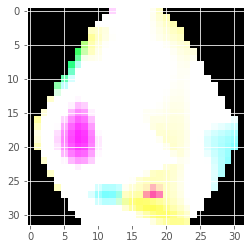

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[10])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [ ]:
y_train.shape

(44525,)

In [ ]:
# input image dimensions
img_rows, img_cols = 32, 32

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (44525, 32, 32, 3)
44525 train samples
11132 test samples


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

num_classes = 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [ ]:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',  # categorical_crossentropy
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [ ]:
batch_size = 64
epochs = 500

In [ ]:
pathModelSave = '/content/drive/My Drive/saveModels/epi_eeg_'+str(image_size)+'_'+str(epochs)+'_'+str(batch_size)+'_.hdf5'
pathToSaveCSV = '/content/drive/My Drive/saveModels/epi_eeg_'+str(image_size)+'_'+str(epochs)+'_'+str(batch_size)+'_.csv'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

checkpoint = ModelCheckpoint(pathModelSave, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')

tic = time.clock()
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [checkpoint, csv_logger], 
          validation_data=(x_test, y_test),
          shuffle=True,
          verbose=1)
toc = time.clock()

print("Total training time is: ", (toc-tic))

Train on 44525 samples, validate on 11132 samples
Epoch 1/500
44525/44525 [==============================] - 11s 256us/step - loss: 0.6008 - accuracy: 0.6953 - val_loss: 0.5861 - val_accuracy: 0.7099

Epoch 00001: val_accuracy improved from -inf to 0.70994, saving model to /content/drive/My Drive/saveModels/epi_eeg_32_500_64_.hdf5
Epoch 2/500
44525/44525 [==============================] - 4s 100us/step - loss: 0.5441 - accuracy: 0.7409 - val_loss: 0.5318 - val_accuracy: 0.7458

Epoch 00002: val_accuracy improved from 0.70994 to 0.74578, saving model to /content/drive/My Drive/saveModels/epi_eeg_32_500_64_.hdf5
Epoch 3/500
44525/44525 [==============================] - 4s 99us/step - loss: 0.5058 - accuracy: 0.7579 - val_loss: 0.5082 - val_accuracy: 0.7511

Epoch 00003: val_accuracy improved from 0.74578 to 0.75108, saving model to /content/drive/My Drive/saveModels/epi_eeg_32_500_64_.hdf5
Epoch 4/500
44525/44525 [==============================] - 4s 98us/step - loss: 0.4846 - accuracy:

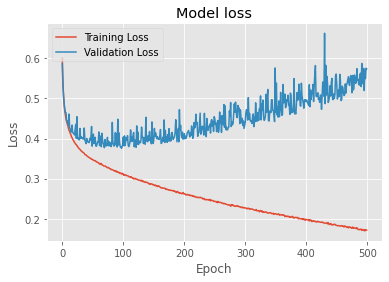

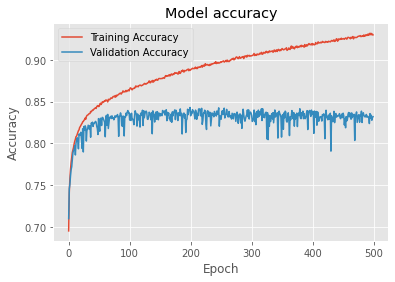

In [ ]:
# author Manoj kaushik

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [ ]:
print("Total training time is: ", (toc-tic)/60)

Total training time is:  39.20927758333333


In [ ]:
# validation accuracies

# acc with 200 epochs 81.25%
# acc with 500 epochs 83.435%
# acc with 1000 epochs 82.160%, training time 3.35 hours, batch size 32
# acc with 1000 epochs 81.818%, training time 1.98 hours, batch size 64
# acc is 84.271%, training time 41.06 minutes, image_size 32, epochs 300, batch size 64
# acc is 83.390%, training time 41.06 minutes, image_size 32, epochs 500, batch size 64

_, acc = model.evaluate(x_test, y_test, verbose=0)
print('acc is> %.3f' % (acc* 100.0))

acc is> 83.193


In [ ]:
print(pathModelSave)

/content/drive/My Drive/saveModels/epi_eeg_32_500_64_.hdf5


In [ ]:
# testing accuracies
import time
from keras.models import load_model
# model = load_model('/content/drive/My Drive/saveModels/epi_eeg_1_32_300__.hdf5')
model = load_model(pathModelSave)

filename = '/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/epilipsy/'
list = os.listdir(filename)
list.sort()

tic = time.clock()
count = 0
count_control = 0
for name in list:
    count += 1
    file = os.path.join(filename, name)
    file_names = []
    file_names.append(file)
    label = [0]
    X, y = make_data_pipeline(file_names, labels, image_size, frame_duration, overlap)
    p = model.predict(X)
    final = np.sum(p, axis = 0)
    if final[0] > final[1]:
      count_control += 1
      print(count, '. ', name, ": Control predicted")
    else:
      print(count, '. ', name, ": Epilipsy Pridicted")  

toc = time.clock()
total_ele = len(list)
# # print(total_ele)
# labels = [0]*total_ele

# print(file_names)
# print(type(labels))
# print(labels)

1 .  transposed-EEG_Eye_State_no_outliers-signal-500-1.csv.gz.csv : Epilipsy Pridicted
2 .  transposed-EEG_Eye_State_no_outliers-signal-501-1.csv.gz.csv : Epilipsy Pridicted
3 .  transposed-EEG_Eye_State_no_outliers-signal-502-1.csv.gz.csv : Epilipsy Pridicted
4 .  transposed-EEG_Eye_State_no_outliers-signal-503-1.csv.gz.csv : Epilipsy Pridicted
5 .  transposed-EEG_Eye_State_no_outliers-signal-504-1.csv.gz.csv : Epilipsy Pridicted
6 .  transposed-EEG_Eye_State_no_outliers-signal-505-1.csv.gz.csv : Epilipsy Pridicted
7 .  transposed-EEG_Eye_State_no_outliers-signal-506-1.csv.gz.csv : Epilipsy Pridicted
8 .  transposed-EEG_Eye_State_no_outliers-signal-507-1.csv.gz.csv : Epilipsy Pridicted
9 .  transposed-EEG_Eye_State_no_outliers-signal-508-1.csv.gz.csv : Epilipsy Pridicted
10 .  transposed-EEG_Eye_State_no_outliers-signal-509-1.csv.gz.csv : Epilipsy Pridicted
11 .  transposed-EEG_Eye_State_no_outliers-signal-510-1.csv.gz.csv : Epilipsy Pridicted
12 .  transposed-EEG_Eye_State_no_outlier

In [ ]:
print('total prediction time for: ',total_ele,' files is ', (toc - tic)/60, 'minutes')
print('total files: ', total_ele)
print('predicted control: ', count_control)
print('predicted epilipsy: ', total_ele - count_control)

total prediction time for:  128  files is  10.984613016666662 minutes
total files:  128
predicted control:  4
predicted epilipsy:  124


In [ ]:
# total files:  93 from control folder
# predicted control:  20
# predicted epilipsy:  73
#    -------------------------
# total prediction time for:  128  files is  14.333447216666666 minutes, from epilipsy folder
# total files:  128
# predicted control:  7
# predicted epilipsy:  121

##############################################

# total prediction time for:  93  files is  10.951726783333333 minutes, from control folder
# total files:  93
# predicted control:  13
# predicted epilipsy:  80
#    -------------------------
# total prediction time for:  128  files is  14.357096983333333 minutes, from epilipsy folder
# total files:  128
# predicted control:  5
# predicted epilipsy:  123

In [ ]:
# X, y = make_data_pipeline(file_names, labels, image_size, frame_duration, overlap)

In [ ]:
print(X.shape)
print(y.shape)

(513, 32, 32, 3)
(513,)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[525])

IndexError: ignored

In [ ]:
p = model.predict(X)

In [ ]:
print(p.shape)
print(type(p))
print(p)

In [ ]:
print(np.sum(p, axis = 0))